In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import json
import os
from collections import defaultdict
from functools import lru_cache
from itertools import product

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from divopt.evaluation.process_results import get_sorted_optimizers, load_results
from divopt.utils import filterdf

In [14]:
runs_base = "../runs/"
results_dict = load_results(runs_base)
limit_names = list(results_dict.keys())

In [15]:
with open("../data/global_settings.json") as f:
    global_settings = json.load(f)
print(global_settings)

SCORE_THRESHOLD = 0.5
SAMPLE_LIMIT = global_settings["sample_budget"]
TIME_LIMIT = global_settings["time_budget"]

{'score_threshold': 0.5, 'distance_threshold': 0.7, 'time_budget': 600, 'sample_budget': 10000, 'n_jobs': 8}


In [16]:
@lru_cache(maxsize=10)
def get_solution_curve(fname, limit_name):
    dir_name = os.path.dirname(fname)
    init_name = "all"  # "novel" is the other option
    diverse_fname = f"results_diverse_{init_name}_{limit_name}.csv"
    df_diverse = pd.read_csv(os.path.join(dir_name, diverse_fname))

    # calculate number of solutions for the limits
    if limit_name == "time":
        xs = np.linspace(0, TIME_LIMIT, 50)
        compound_times = df_diverse["Total time [s]"].to_numpy()
        n_solutions = np.array([np.sum(compound_times <= t) for t in xs])
    elif limit_name == "samples":
        xs = np.arange(0, SAMPLE_LIMIT, 100)
        unique_idx = df_diverse["unique_idx"].to_numpy()
        n_solutions = np.array([np.sum(unique_idx <= t) for t in xs])
    return xs, n_solutions


def get_curves(df_config, limit_name):
    all_curves = defaultdict(dict)
    for optimizer_name, task_name in product(df_config.Optimizer.unique(), df_config.Task.unique()):
        all_curves[task_name][optimizer_name] = []
        df_sub = filterdf(df_config, {"Optimizer": optimizer_name, "Task": task_name})
        for _, row in df_sub.iterrows():
            task_name = row["Task"]
            optimizer_name = row["Optimizer"]
            try:
                xs, n_solutions = get_solution_curve(row["results_fname"], limit_name)
                if len(xs) == 0:
                    print("hi")
                all_curves[task_name][optimizer_name].append((xs, n_solutions))
            except Exception as e:
                print(f"Failed for {row['results_fname']}")
                print(e)
    return all_curves

In [17]:
# colors = matplotlib.cm.tab20(range(15))  # type: ignore

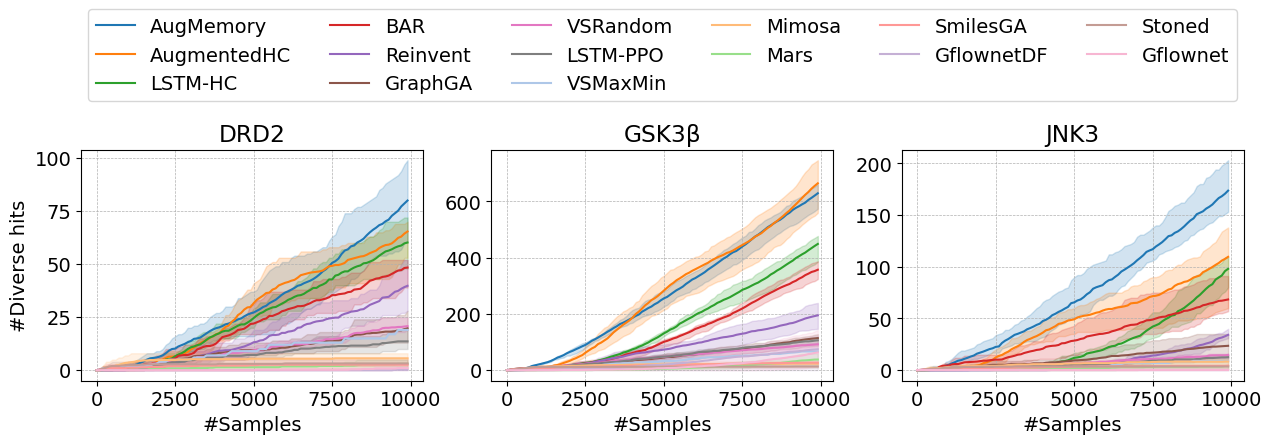

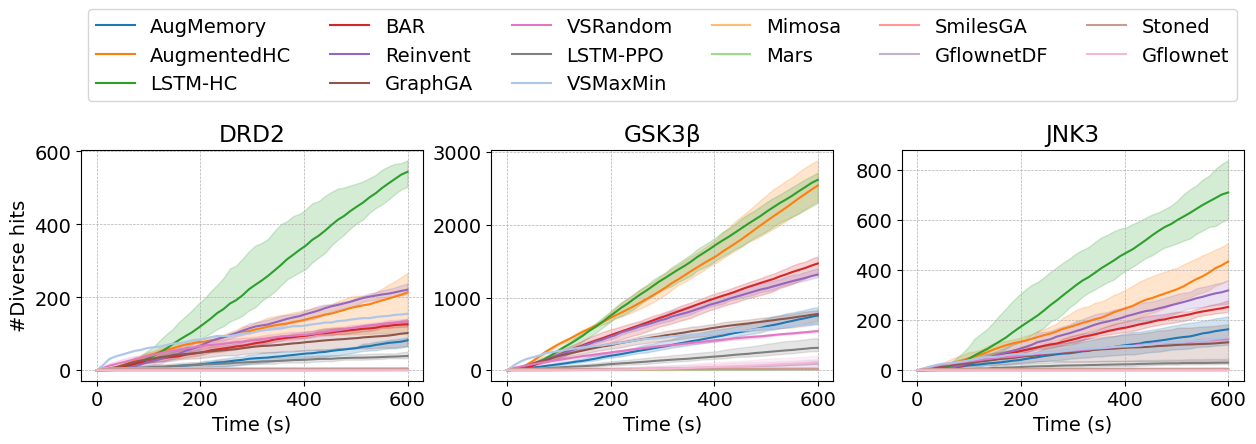

In [18]:
# Dictionary for x-axis labels
xlabel_dict = {"samples": "#Samples", "time": "Time (s)"}


def plot_curves(task_curves, ax, task_name, limit_name, yscale="linear", shade="std"):
    """
    Plots curves on a given axis.

    Parameters:
    task_curves (dict): Dictionary of curves to plot.
    ax (matplotlib.axes.Axes): Axes object to plot on.
    task_name (str): Name of the task.
    limit_name (str): Name of the limit.
    yscale (str): Y-axis scale type.
    shade (str): Type of shading ('std' or 'minmax').
    """
    colors = matplotlib.cm.tab20(range(len(task_curves)))  # type: ignore
    # interleave the colors
    colors = np.concatenate([colors[::2], colors[1::2]], axis=0)

    for i, (opt_name, list_of_pairs) in enumerate(task_curves.items()):
        if not list_of_pairs:
            continue

        x_list, y_list = zip(*list_of_pairs)
        Y = np.array(y_list)
        y_mean = np.mean(Y, axis=0)
        ax.plot(x_list[0], y_mean, label=opt_name, color=colors[i])

        if shade == "std":
            y_std = np.std(Y, axis=0)
            ax.fill_between(x_list[0], y_mean - y_std, y_mean + y_std, alpha=0.2, color=colors[i])
        elif shade == "minmax":
            ax.fill_between(x_list[0], Y.min(axis=0), Y.max(axis=0), alpha=0.2, color=colors[i])

        ax.set_title(task_name)
        ax.set_xlabel(xlabel_dict[limit_name])
        ax.set_yscale(yscale)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)


plt.rcParams.update({"font.size": 14})
sorted_optimizers = get_sorted_optimizers(results_dict["samples"], limit_name="samples")


for limit_name, yscale in zip(["samples", "time"], ["linear", "linear"]):
    results = results_dict[limit_name]
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))
    all_curves = get_curves(results, limit_name)
    for ax, (task_name, task_curves) in zip(axs, all_curves.items()):
        sorted_task_curves = {opt_name: task_curves[opt_name] for opt_name in sorted_optimizers}
        plot_curves(sorted_task_curves, ax, task_name, limit_name, yscale=yscale, shade="minmax")

    axs[0].set_ylabel("#Diverse hits")
    axs[0].legend(loc="upper center", bbox_to_anchor=(1.7, 1.65), ncol=6)

    fig.savefig(f"figures/divhits_curve_{limit_name}.pdf", bbox_inches="tight")
    plt.show()